# Определение перспективного тарифа для телеком компании "Мегалайн"

*Задача*

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Навигатор**

1. [Открытие данных, изучение общей информации](#start)
2. [Подготовка данных](#preprocessing)
    * [Шаг 2.1. Изменение типов данных](#types)
    * [Шаг 2.2. Поиск и исправление ошибок](#errors)
    * [Шаг 2.3. Расчёт количества сделанных звонков и израсходованных минут разговора по месяцам](#calls)
    * [Шаг 2.4. Расчёт количества отправленных сообщений по месяцам](#messages)
    * [Шаг 2.5. Расчёт объема израсходованного интернет-трафика по месяцам](#internet)
    * [Шаг 2.6. Расчёт помесячной выручки с каждого пользователя](#income)
3. [Анализ данных](#analyse)
4. [Проверка гипотез:](#investigate)
    * [Шаг 4.1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается](#hyp_01)
    * [Шаг 4.2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов](#hyp_02)
5. [Общий вывод](#final)

*Импорт библиотек*

In [175]:
# Все Бмблиотеки проекта
import pandas as pd

import numpy as np

from scipy import stats as st

# импортируем pymystem3
from pymystem3 import Mystem

# Графики
import matplotlib.pyplot as plt

# библиотека для загрузки файлов
import os
import urllib
from pathlib import Path

<a id="start"></a>
### Шаг 1. Открытие данных, изучение общей информации. 

*Путь к файлам:*
-	/datasets/calls.csv
-	/datasets/internet.csv
-	/datasets/messages.csv
-	/datasets/tariffs.csv
-	/datasets/users.csv


In [176]:
# Проверка налчия файла в локальной папке, при отсутствии подкачка по URL
Path('datasets').mkdir(parents= True, exist_ok= True)

def get_file(file_name, url):
    # Есть ли файл ?
    if not os.path.exists(file_name):
        print(file_name, 'файл не найден, будет загружен из сети')
        # Скачаем файл по ссылке url, кладем по пути file_name
        _ = urllib.request.urlretrieve(url, file_name)

# Словарь с именем файла и ссылкой на него
urls = {'calls':('/datasets/calls.csv', 'https://code.s3.yandex.net/datasets/calls.csv'),
        'internet':('/datasets/internet.csv', 'https://code.s3.yandex.net/datasets/internet.csv'),
        'messages':('/datasets/messages.csv', 'https://code.s3.yandex.net/datasets/messages.csv'),
        'tariffs':('/datasets/tariffs.csv', 'https://code.s3.yandex.net/datasets/tariffs.csv'),
        'users':('/datasets/users.csv', 'https://code.s3.yandex.net/datasets/users.csv')
}

# Подкачка файлов
[get_file(*urls[url]) for url in urls]

# Чтение в датафрейм
calls = pd.read_csv(urls['calls'][0])
internet = pd.read_csv(urls['internet'][0])
messages = pd.read_csv(urls['messages'][0])
tariffs = pd.read_csv(urls['tariffs'][0])
users = pd.read_csv(urls['users'][0])

<div class="alert alert-success">
<h2> Комментарий ревьюера </h2>

Вау! Профессиональная загрузка файлов

</div>

In [177]:
# Изучение общей информации таблиц будем делать по одному сценарию
def show_info(table):
    table.info() # Общая информация
    print('\nНаименования столбцов:')
    print(table.columns) # для проверки наименований столбцов
    print('\nПропущенные значения')
    print(table.isnull().sum())
    print('\nДубликаты:', table.duplicated().sum())
    display(table.head(5))

Таблица **users** (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

In [178]:
# Изучение общей информации
show_info(users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB

Наименования столбцов:
Index(['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff'],
      dtype='object')

Пропущенные значения
user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

Дубликаты: 0


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


462 пропущенных значения в столбце churn_date означают, что тариформ продолжают пользоваться. А 38 пользоватлей прекратили. Пропущенные значения заменим на последнюю дату выборки.

In [179]:
users.loc[users['churn_date'].isna(), 'churn_date'] = '2018-12-31'
users.head(2)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,2018-12-31,Москва,Иван,Ежов,2018-11-01,smart


In [180]:
print('Уникальных пользователей:', len(users['user_id'].unique()))

Уникальных пользователей: 500


*Вывод по таблице users:*

- 500 значений (пользователей)
- 462 пропущенных значения в столбце churn_date означают, что тариформ продолжают пользоваться. А 38 пользоватлей прекратили. Пропущенные значения заменили на последнюю дату выборки.
- churn_date - можно преобразовать в формат даты
- reg_date - можно преобразовать в формат даты
- tariff - есть возможность сделать данные компактнее за счет вынесения наименования тарифов в отдельную таблицу или конвертирования в булев тип. Но не будем этого делать т.к. выборка невелика.

Таблица **calls** (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок


In [181]:
# Изучение общей информации
show_info(calls)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB

Наименования столбцов:
Index(['id', 'call_date', 'duration', 'user_id'], dtype='object')

Пропущенные значения
id           0
call_date    0
duration     0
user_id      0
dtype: int64

Дубликаты: 0


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [182]:
total_calls = calls.shape[0]
missed_calls = calls.query('duration == 0')['duration'].count()
rate_missed_calls = missed_calls / total_calls

print('Уникальных записей звонков:', len(calls['id'].unique()))
print('Уникальных пользователей:', len(calls['user_id'].unique()))
print('Пропущенных звонков: {:.0f}, что составляет: {:.1%} от общего числа записей ({:.0f})'
      .format(missed_calls, rate_missed_calls, total_calls)
     )

Уникальных записей звонков: 202607
Уникальных пользователей: 492
Пропущенных звонков: 39613, что составляет: 19.6% от общего числа записей (202607)


*Вывод по таблице calls:*
- 202067 записей о звонках
- call_date можно преобразовать в тип дата
- Пропущенных звонков: 39613, что составляет: 19.6% от общего числа записей (202607)
- В выборку попали 492 пользователя. Позже узнаем обо всех ли у нас есть сведения в users?

Таблица **messages** (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

In [183]:
show_info(messages)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB

Наименования столбцов:
Index(['id', 'message_date', 'user_id'], dtype='object')

Пропущенные значения
id              0
message_date    0
user_id         0
dtype: int64

Дубликаты: 0


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [184]:
print('Уникальных пользователей:', len(messages['user_id'].unique()))

Уникальных пользователей: 426


*Вывод по таблице messages:*
- 123036 записей о сообщениях, которые совершили 426 пользоватлей
- message_date можно преобразовать в тип дата

Таблица **internet** (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

In [185]:
show_info(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB

Наименования столбцов:
Index(['Unnamed: 0', 'id', 'mb_used', 'session_date', 'user_id'], dtype='object')

Пропущенные значения
Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

Дубликаты: 0


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Обнаружен лишний столбец "Unnamed: 0". Вероятнее всего это дубликат индекса и не одержит полезной информации.
Догадку проверим посчитав уникальные значения.

In [186]:
print(len(internet['Unnamed: 0'].unique()))

149396


Столбец не несет нкакого смысла. Удаляем.

In [187]:
internet.drop(columns= 'Unnamed: 0', inplace=True)
internet.columns

Index(['id', 'mb_used', 'session_date', 'user_id'], dtype='object')

In [188]:
print('Уникальных пользователей:', len(internet['user_id'].unique()))

Уникальных пользователей: 497


*Вывод по таблице internet:*
- 149396 записей (сессий), совершенных 497 пользователями
- session_date можно преобразовать в тип дата
- удлаен лишний столбец 'Unnamed: 0'

Таблица **tariffs** (информация о тарифах):
-	tariff_name — название тарифа
-	rub_monthly_fee — ежемесячная абонентская плата в рублях
-	minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
-	messages_included — количество сообщений в месяц, включённых в абонентскую плату
-	mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
-	rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
-	rub_per_message — стоимость отправки сообщения сверх тарифного пакета
-	rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [189]:
show_info(tariffs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes

Наименования столбцов:
Index(['messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff_name'],
      dtype='object')

Пропущенные значения
messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff_name              0
dtype: int64

Дубликаты: 0


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


*Описание тарифов*

Тариф **«Смарт»**
1.	Ежемесячная плата: 550 рублей
2.	Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета:
        - минута разговора: 3 рубля
        - сообщение: 3 рубля
        - 1 Гб интернет-трафика: 200 рублей

Тариф **«Ультра»**
1.	Ежемесячная плата: 1950 рублей
2.	Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета:
        - минута разговора: 1 рубль
        - сообщение: 1 рубль
        - 1 Гб интернет-трафика: 150 рублей

*Вывод по таблице tariffs:*

Таблица, описывающая парметры двух тарифов. Замечаний по содержанию нет.

## Вывод по изучению общей информации:

*Вывод по таблице users:*
- 500 значений (пользователей)
- 462 пропущенных значения в столбце churn_date означают, что тарифом продолжают пользоваться. А 38 пользоватлей прекратили.
- churn_date - можно преобразовать в формат даты
- reg_date - можно преобразовать в формат даты

*Вывод по таблице calls:*
- 202067 записей о звонках (в выборку попали 492 пользователя)
- call_date можно преобразовать в тип дата
- Пропущенных звонков: 39613, что составляет: 19.6% от общего числа записей (202607)

*Вывод по таблице messages:*
- 123036 записей о сообщениях, которые совершили 426 пользоватлей
- message_date можно преобразовать в тип дата

*Вывод по таблице internet:*
- 149396 записей (сессий), совершенных 497 пользователями
- session_date можно преобразовать в тип дата
- удлаен лишний столбец 'Unnamed: 0'

*Вывод по таблице tariffs:*
Таблица, описывающая парметры двух тарифов. Замечаний по содержанию нет.

На следующем этапе предстоит провести поиск ошибок, расчёты и слияние данных. Позже узнаем обо всех ли у нас есть сведения в users?

<a id="preprocessing"></a>
### Шаг 2. Подготовка данных
<a id="types"></a>
#### Шаг 2.1. Изменение типов данных

Предстоит измнить тип данных у 5 столбцов. Чтобы сократить код, сделаем функцию

In [190]:
def convert_to_date(column_with_text):
    try:  
        x_column = pd.to_datetime(column_with_text, format='%Y-%m-%dT%H:%M:%S') 
        print(column_with_text.name,'- Ok')
        return x_column
    except:
        print(column_with_text.name,'- Есть неконвертируемые значения.')
        return column_with_text

Изменяем столбцы

users:
- churn_date - можно преобразовать в формат даты
- reg_date - можно преобразовать в формат даты

calls:
- call_date можно преобразовать в тип дата

massages:
- message_date можно преобразовать в тип дата

internet:
- session_date можно преобразовать в тип дата

In [191]:
users['churn_date'] = convert_to_date(users['churn_date'])
users['reg_date'] = convert_to_date(users['reg_date'])
calls['call_date'] = convert_to_date(calls['call_date'])
messages['message_date'] = convert_to_date(messages['message_date'])
internet['session_date'] = convert_to_date(internet['session_date'])

churn_date - Ok
reg_date - Ok
call_date - Ok
message_date - Ok
session_date - Ok


#### Вывод по изменению типов данных

5 столбцов из разных таблиц переведены в тип data успешно.

<a id="errors"></a>
#### Шаг 2.2. Поиск и исправление ошибок

Таблица users (информация о пользователях):

- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

Проверим:
- first_name, last_name, city - не пустые строки
- age - min, max
- reg_date, churn_date - min, max
- tariff - принимает только 2 значения

In [192]:
users.query('(first_name == "") or (last_name == "") or (city == "")')

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff


Пустых строк нет.

In [193]:
def min_max_show(column):
    print(column.name, ': min =', column.min(), ', max =', column.max())

In [194]:
min_max_show(users['age'])
min_max_show(users['reg_date'])
min_max_show(users['churn_date'])

age : min = 18 , max = 75
reg_date : min = 2018-01-01 00:00:00 , max = 2018-12-31 00:00:00
churn_date : min = 2018-08-17 00:00:00 , max = 2018-12-31 00:00:00


Данные в нормальных границах.

Таблица calls (информация о звонках):

- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id— идентификатор пользователя, сделавшего звонок

Проверим:

- call_date - min, max
- duration - min, max и график

In [195]:
min_max_show(calls['call_date'])
min_max_show(calls['duration'])

call_date : min = 2018-01-01 00:00:00 , max = 2018-12-31 00:00:00
duration : min = 0.0 , max = 38.0


Даты звонка в нормальном диапазоне.

Есть звонки с нулевой длительностью. Мы их считаем пропущенными звонками. Это было выяснено на Шаге 1.

Пропущенных звонков: 39613, что составляет: 19.6% от общего числа записей (202607)

Посмотрим распределение на графике.

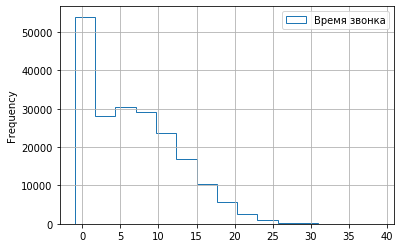

In [196]:
calls.plot(kind='hist', y='duration', histtype='step', range=(-1, 39),
          bins=15, label='Время звонка', grid=True, legend=True)
plt.show()

Частота длительностей звонка выглядит логично.

Таблица messages (информация о сообщениях):

- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Проверим: message_date - min, max

In [197]:
min_max_show(messages['message_date'])

message_date : min = 2018-01-02 00:00:00 , max = 2018-12-31 00:00:00


Информация о сообщениях в ожидаемый период  - 2018 год.

Таблица **internet** (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Проверим:
- mb_used — min, max и график
- session_date — min, max

In [198]:
min_max_show(internet['session_date'])
min_max_show(internet['mb_used'])

session_date : min = 2018-01-01 00:00:00 , max = 2018-12-31 00:00:00
mb_used : min = 0.0 , max = 1724.83


Даты сессий в ожидаемый период.

Есть сессии с 0-м трафиком. Посмотрим графически.

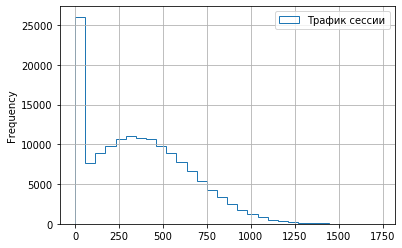

In [199]:
internet.plot(kind='hist', y='mb_used', histtype='step', range=(-1, 1730),
          bins=30, label='Трафик сессии', grid=True, legend=True)
plt.show()

Вид графика логичен.

In [200]:
internet_total = internet.shape[0]
internet_zero_sessions = internet.query('mb_used == 0')['mb_used'].count()
print('Нашлось', internet_zero_sessions, 'нулевых интернет-сессий,')
print('что составляет {:.2%} от общего числа записей {:.0f}'.format(internet_zero_sessions/internet_total, internet_total))

Нашлось 19598 нулевых интернет-сессий,
что составляет 13.12% от общего числа записей 149396


Таблицу **tarriffs** уже проверили.

А теперь проверим, насколько соответствуют у нас данные о польователях и данные о всех потребляемых услугах. Для этого проверим входят ли все user_id из таблиц calls, messages и internet в таблицу users.

Данных в таблице пользователей может быть больше (не все воспольовались услугами), но не меньше (данные об услугах есть, но нет информации о пользователе). 

In [201]:
calls_user_ids = calls['user_id'].unique()
messages_user_ids = messages['user_id'].unique()
internet_user_ids = internet['user_id'].unique()

def check_user_ids(id_list, list_name):
    c = 0
    for id in id_list:
        if id not in users['user_id'].values:
            c += 1
    if c > 0:
        print('не хватает данных о {:.0f} пользователях в таблице:'.format(c), list_name)
    else:
        print('Все user_id в таблице', list_name, 'найдены.')
    return

check_user_ids(calls_user_ids,'calls')
check_user_ids(messages_user_ids,'messages')
check_user_ids(internet_user_ids,'internet')

Все user_id в таблице calls найдены.
Все user_id в таблице messages найдены.
Все user_id в таблице internet найдены.


Убедились, что у нас есть данные о всех пользователях.

#### Вывод

Из прблем в данных нашлись следующие:

Пропущенных звонков: 39613, что составляет: 19.6% от общего числа записей (202607)

Нашлось 19598 нулевых интернет-сессий, что составляет 13.12% от общего числа записей 149396

Эту информацию нельзя назвать некорректной. Оставляем как есть.

<a id="calls"></a>
#### Шаг 2.3. Расчёт количества сделанных звонков и израсходованных минут разговора по месяцам

Добавим в таблицу *calls* столбец month который будет содержать месяц звонка. 

,calls_count,duration
month,,
1,1476,10206.44
2,3328,23145.58
3,6687,45433.85
4,9272,62530.92
5,12647,83770.77
6,14716,99249.71
7,18298,124373.23
8,21488,145071.63
9,24061,163723.16


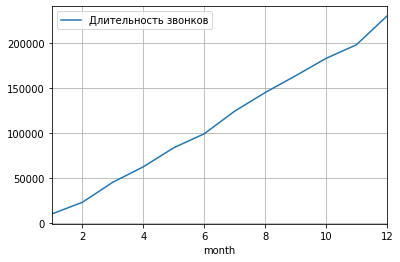

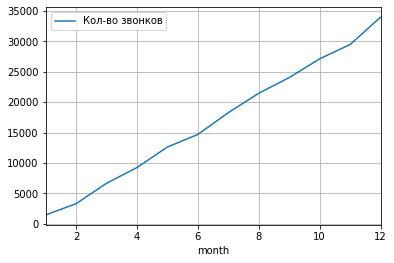

In [202]:
calls['month'] = calls['call_date'].dt.month

calls_stat = pd.DataFrame(calls.groupby('month').agg({'id':'count', 'duration':'sum'}))
# Переименуем столбец id в calls_count для наглядности
calls_stat.set_axis(['calls_count','duration'], axis = 'columns', inplace = True)

calls_stat.plot(kind='line', y='duration', label='Длительность звонков', grid=True, legend=True)
calls_stat.plot(kind='line', y='calls_count', label='Кол-во звонков', grid=True, legend=True)

calls_stat

Довольно интересно, что количество и продолжительность звонков практически линейнорастут с каждым месяцем.
Как будьто мы наблюдаем развитие компании или новой линейки тарифных планов.

<a id="messages"></a>
#### Шаг 2.4. Расчёт количества отправленных сообщений по месяцам

Проделаем это аналогично длительности разговоров.

,messages_count
month,
1,924
2,1924
3,3648
4,5179
5,7298
6,8983
7,11320
8,13088
9,14759


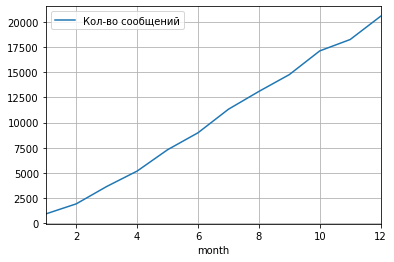

In [203]:
messages['month'] = messages['message_date'].dt.month

messages_stat = pd.DataFrame(messages.groupby('month').agg({'id':'count'}))
# Переименуем столбец id в messages_count для наглядности
messages_stat.set_axis(['messages_count'], axis = 'columns', inplace = True)

messages_stat.plot(kind='line', y='messages_count', label='Кол-во сообщений', grid=True, legend=True)

messages_stat

<a id="internet"></a>
#### Шаг 2.5. Расчёт объема израсходованного интернет-трафика по месяцам

И снова.

,sessions_count,mb_used
month,,
1,1117,407732.53
2,2641,955251.65
3,4885,1811835.61
4,6511,2433311.62
5,9408,3525862.24
6,11057,4180017.17
7,13548,5029478.75
8,16092,5998157.07
9,17512,6447422.36


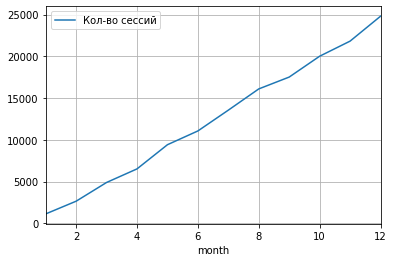

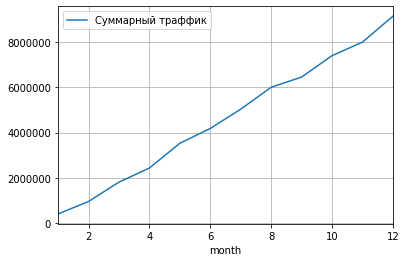

In [204]:
internet['month'] = internet['session_date'].dt.month

internet_stat = pd.DataFrame(internet.groupby('month').agg({'id':'count','mb_used':'sum'}))
# Переименуем столбец id в messages_count для наглядности
internet_stat.set_axis(['sessions_count', 'mb_used'], axis = 'columns', inplace = True)

internet_stat.plot(kind='line', y='sessions_count', label='Кол-во сессий', grid=True, legend=True)
internet_stat.plot(kind='line', y='mb_used', label='Суммарный траффик', grid=True, legend=True)

internet_stat

<a id="income"></a>
#### Шаг 2.6. Расчёт помесячной выручки с каждого пользователя

Чтобы понять помесячную выручку нужно посчитать объем услуг (звонки, сообщения, интернет) потребляемый, каждым пользователем и тарифицировать в соответствии с тарифнм планом.

Создадим новую таблицу объединяющую нужные данные. (Мы уже убедились, что у нас есть данные о всех пользователях, поэтому не должно быть проблем со слиянием).

In [205]:
# Во главе у нас полный список пользователей
# Т.к. мы должны посчитать тарификацию для всех пользователей, дае если они не пользовались услугами
tariff_stat = pd.DataFrame([])
tariff_stat = users[['user_id', 'tariff', 'reg_date','churn_date']]

In [206]:
# Проставим начальный и конечны месяц тарифа
tariff_stat.loc[:,'month_begin'] = tariff_stat['reg_date'].dt.month
tariff_stat.loc[:,'month_end'] = tariff_stat['churn_date'].dt.month
tariff_stat.head(5)

,user_id,tariff,reg_date,churn_date,month_begin,month_end
0,1000,ultra,2018-05-25,2018-12-31,5,12
1,1001,smart,2018-11-01,2018-12-31,11,12
2,1002,smart,2018-06-17,2018-12-31,6,12
3,1003,ultra,2018-08-17,2018-12-31,8,12
4,1004,ultra,2018-05-14,2018-12-31,5,12


Сделаем заготовку на основе известной информации о тарифах. Впишем помесячную оплату для каждого месяца.

Не забудем учесть дату подключения и отключения тарифа.

In [207]:
# Пустой датафрейм
for i in range(1,13):
    temp = pd.DataFrame(tariff_stat['user_id'])
    temp[i] = 0
    tariff_stat = tariff_stat.merge(temp, on= 'user_id', how='left')
tariff_stat.head(5)

,user_id,tariff,reg_date,churn_date,month_begin,month_end,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,ultra,2018-05-25,2018-12-31,5,12,0,0,0,0,0,0,0,0,0,0,0,0
1,1001,smart,2018-11-01,2018-12-31,11,12,0,0,0,0,0,0,0,0,0,0,0,0
2,1002,smart,2018-06-17,2018-12-31,6,12,0,0,0,0,0,0,0,0,0,0,0,0
3,1003,ultra,2018-08-17,2018-12-31,8,12,0,0,0,0,0,0,0,0,0,0,0,0
4,1004,ultra,2018-05-14,2018-12-31,5,12,0,0,0,0,0,0,0,0,0,0,0,0


Заполним абонентской платой месяца в которых тариф действителен.

In [208]:
# Заполнение Абонентской платой

for i in range(1,13):
    for k,row in tariffs.iterrows():
        t_name = row['tariff_name']
        criteria = '(tariff == @t_name) and (@i >= month_begin) and (@i <= month_end)'
        tariff_stat.loc[tariff_stat.eval(criteria),i] = row['rub_monthly_fee']

# Примеры таблиц
display(tariff_stat.head(5))
display(tariff_stat.query('month_end < 12').head(5))

,user_id,tariff,reg_date,churn_date,month_begin,month_end,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,ultra,2018-05-25,2018-12-31,5,12,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950
1,1001,smart,2018-11-01,2018-12-31,11,12,0,0,0,0,0,0,0,0,0,0,550,550
2,1002,smart,2018-06-17,2018-12-31,6,12,0,0,0,0,0,550,550,550,550,550,550,550
3,1003,ultra,2018-08-17,2018-12-31,8,12,0,0,0,0,0,0,0,1950,1950,1950,1950,1950
4,1004,ultra,2018-05-14,2018-12-31,5,12,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950


,user_id,tariff,reg_date,churn_date,month_begin,month_end,1,2,3,4,5,6,7,8,9,10,11,12
19,1019,ultra,2018-05-16,2018-10-05,5,10,0,0,0,0,1950,1950,1950,1950,1950,1950,0,0
34,1034,smart,2018-08-26,2018-11-21,8,11,0,0,0,0,0,0,0,550,550,550,550,0
50,1050,ultra,2018-06-16,2018-10-03,6,10,0,0,0,0,0,1950,1950,1950,1950,1950,0,0
51,1051,smart,2018-05-28,2018-10-14,5,10,0,0,0,0,550,550,550,550,550,550,0,0
56,1056,smart,2018-04-13,2018-10-14,4,10,0,0,0,550,550,550,550,550,550,550,0,0


Заготовка таблицы получена. В таблице проставлены обязательные ежемесячные платежи.

**Округляем минуты и мегабайты**

Обратите внимание: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

In [209]:
# Округляем звонки до целых минут
calls.loc[:,'duration'] = np.ceil(calls['duration'])

# Окургляем мегабайты в сессиях до целых.
internet.loc[:,'mb_used'] = np.ceil(internet['mb_used'])

Теперь займемся рассчетом платежей сверх тарифного плана.

Сначала создадим таблицу с объединенными данными для расчета.

In [223]:
# Все записи тарификации объединим в этом DF
months_stat = pd.DataFrame({'month' : [1,2,3,4,5,6,7,8,9,10,11,12]})

# Получаем все самые необходимые данные о всех звонках
# Сводим сводной таблицей (суммруем минуты за месяц)
# Для простоты дальнейшей адресации сбрасываем индексы
calls_stat = calls.pivot_table(index= ['user_id', 'month'], values= 'duration', aggfunc= 'sum').reset_index()

# Объединяем с таблицей по месяцам
months_stat = months_stat.merge(calls_stat, on= 'month', how= 'outer')

# Получаем самые необходимые данные о сообщениях
# Сводим сводной таблицей - подсчет числа сообщений методом count
messages_stat = messages.pivot_table(index= ['user_id', 'month'], values= 'id', aggfunc= 'count').reset_index()
# Переименуем столбцы для наглядности
messages_stat.columns = ['user_id', 'month', 'messages']

# Объединяем с таблицей по месяцам
# Здесь объединение идет по двум столбцам
months_stat = months_stat.merge(messages_stat, on= ['user_id', 'month'], how= 'outer')

# Получаем самые необходимые данные о сессиях интернета
# Сводим сводной таблицей (суммруем Мегабайты за месяц)
internet_stat = internet.pivot_table(index= ['user_id', 'month'], values= 'mb_used', aggfunc= 'sum').reset_index()

# Объединяем с таблицей по месяцам
# Здесь объединение идет по двум столбцам
months_stat = months_stat.merge(internet_stat, on= ['user_id', 'month'], how= 'outer')

# Прицепим тариф
months_stat = months_stat.merge(users[['user_id','tariff']], on= 'user_id', how= 'left')

months_stat

,month,user_id,duration,messages,mb_used,tariff
0,1,1005,95.0,7.0,2730.0,smart
1,1,1032,380.0,38.0,24147.0,smart
2,1,1045,9.0,5.0,2348.0,smart
3,1,1055,551.0,30.0,17111.0,smart
4,1,1071,194.0,16.0,15622.0,smart
...,...,...,...,...,...,...
3209,9,1489,NaN,32.0,17232.0,smart
3210,10,1489,NaN,21.0,19588.0,smart
3211,11,1489,NaN,20.0,17516.0,smart
3212,12,1489,NaN,35.0,17341.0,smart


In [211]:
internet['mb_used'].sum(), months_stat['mb_used'].sum()

(55369459.0, 55369459.0)

In [224]:
print('Calls', calls['duration'].sum(), months_stat['duration'].sum())
print('Messages', messages['id'].count(), messages_stat['messages'].sum())
print('Internet', internet['mb_used'].sum(), months_stat['mb_used'].sum())

Calls 1450301.0 1450301.0
Messages 123036 123036
Internet 55369459.0 55369459.0


Итак, мы получили таблицу со всеми записями оказанных услуг. По ней рассчитаем тарификацию.

In [225]:
# Переименуем столбец в таблице тарифовб чтобы она могла объединяться
tariffs.columns = ['messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff']
# Прицепим лимиты
months_stat = months_stat.merge(tariffs, on= 'tariff', how= 'left')
months_stat

,month,user_id,duration,messages,mb_used,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1,1005,95.0,7.0,2730.0,smart,50,15360,500,550,200,3,3
1,1,1032,380.0,38.0,24147.0,smart,50,15360,500,550,200,3,3
2,1,1045,9.0,5.0,2348.0,smart,50,15360,500,550,200,3,3
3,1,1055,551.0,30.0,17111.0,smart,50,15360,500,550,200,3,3
4,1,1071,194.0,16.0,15622.0,smart,50,15360,500,550,200,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,9,1489,NaN,32.0,17232.0,smart,50,15360,500,550,200,3,3
3210,10,1489,NaN,21.0,19588.0,smart,50,15360,500,550,200,3,3
3211,11,1489,NaN,20.0,17516.0,smart,50,15360,500,550,200,3,3
3212,12,1489,NaN,35.0,17341.0,smart,50,15360,500,550,200,3,3


Теперь посчитаем каждый месяц.

Расчитываем ТОЛЬКО ПРЕВЫШЕНИЯ стандартного пакета.

In [226]:
# Напоминака по тариффным панам
display(tariffs)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [227]:
#months_stat['overtax'] = months_stat.query('duration > minutes_included')

for i, row in months_stat.iterrows():
    months_stat.loc[i, 'calls_over_tax'] = 0
    months_stat.loc[i, 'mess_over_tax'] = 0
    months_stat.loc[i, 'mb_over_tax'] = 0
    if row['duration'] > row['minutes_included']:
        months_stat.loc[i, 'calls_over_tax'] = (row['duration'] - row['minutes_included']) * row['rub_per_minute']
    if row['messages'] > row['messages_included']:
        months_stat.loc[i, 'mess_over_tax'] = (row['messages'] - row['messages_included']) * row['rub_per_message']
    if row['mb_used'] > row['mb_per_month_included']:
        # не забываем окурглить до ГБ
        months_stat.loc[i, 'mb_over_tax'] = np.ceil((row['mb_used'] - row['mb_per_month_included']) / 1024) * row['rub_per_gb']

months_stat.head(5)

,month,user_id,duration,messages,mb_used,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calls_over_tax,mess_over_tax,mb_over_tax
0,1,1005,95.0,7.0,2730.0,smart,50,15360,500,550,200,3,3,0.0,0.0,0.0
1,1,1032,380.0,38.0,24147.0,smart,50,15360,500,550,200,3,3,0.0,0.0,1800.0
2,1,1045,9.0,5.0,2348.0,smart,50,15360,500,550,200,3,3,0.0,0.0,0.0
3,1,1055,551.0,30.0,17111.0,smart,50,15360,500,550,200,3,3,153.0,0.0,400.0
4,1,1071,194.0,16.0,15622.0,smart,50,15360,500,550,200,3,3,0.0,0.0,200.0


Итак, мы посчитали все перерасходы выше тарифа. Оталось только добавить это к расчитанным ранее расходам абонентской платы.

In [228]:
# Перебираем все строки тарификации с превышением
for i, row in months_stat.query('(calls_over_tax > 0) or (mess_over_tax > 0) or (mb_over_tax > 0)').iterrows():
    # Добавлям эти ненулевые значения в соответствующую ячейку таблицы tariff_stat
    user_id = row['user_id']
    month = row['month']
    over_tax = row['calls_over_tax'] + row['mess_over_tax'] + row['mb_over_tax']
    criteria = 'user_id == @user_id'
    tariff_stat.loc[tariff_stat.eval(criteria), month] = over_tax + tariff_stat.loc[tariff_stat.eval(criteria), month]

tariff_stat.query('user_id == 1032').head(10)

,user_id,tariff,reg_date,churn_date,month_begin,month_end,1,2,3,4,5,6,7,8,9,10,11,12
32,1032,smart,2018-01-04,2018-12-31,1,12,2350.0,550.0,2550.0,1013.0,986.0,1350.0,1550.0,2550.0,1171.0,550.0,2150.0,1150.0


#### Вывод
Помесячная выручка для каждого пользователя посчитана в таблице *tariff_stat*.

В таблице months_stat посчитали сохранили превышения тарифа по услгам (звонки, сообщения, интернет).

<a id="analyse"></a>
### Шаг 3. Анализ данных

Коммерческий департамент хочет понять, какой тариф приносит больше денег.

Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

У нас есть информация: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. 

In [229]:
# Сколько месяцев пользуются тарифом
tariff_stat['months_use'] = tariff_stat['month_end'] - tariff_stat['month_begin'] + 1
# Общая выручка с пользователя
tariff_stat['total_income'] = (tariff_stat[1] + tariff_stat[2] + tariff_stat[3] + + tariff_stat[4] +
                                tariff_stat[5] + tariff_stat[6] + tariff_stat[7] + + tariff_stat[8] +
                              tariff_stat[9] + tariff_stat[10] + tariff_stat[11] + + tariff_stat[12])
# Среднемесячная выручка с пользователя
tariff_stat['mean_income'] = tariff_stat['total_income'] / tariff_stat['months_use']

# Подтянем все отсальные данные о пользователях
tariff_stat = tariff_stat.merge(users[['user_id','age', 'city']], on= 'user_id', how= 'left')

tariff_stat.head(5)

,user_id,tariff,reg_date,churn_date,month_begin,month_end,1,2,3,4,...,8,9,10,11,12,months_use,total_income,mean_income,age,city
0,1000,ultra,2018-05-25,2018-12-31,5,12,0.0,0.0,0.0,0.0,...,1950.0,1950.0,1950.0,1950.0,1950.0,8,15600.0,1950.000000,52,Краснодар
1,1001,smart,2018-11-01,2018-12-31,11,12,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1350.0,550.0,2,1900.0,950.000000,41,Москва
2,1002,smart,2018-06-17,2018-12-31,6,12,0.0,0.0,0.0,0.0,...,1550.0,950.0,550.0,1350.0,1150.0,7,7250.0,1035.714286,59,Стерлитамак
3,1003,ultra,2018-08-17,2018-12-31,8,12,0.0,0.0,0.0,0.0,...,1950.0,1950.0,1950.0,1950.0,1950.0,5,9750.0,1950.000000,23,Москва
4,1004,ultra,2018-05-14,2018-12-31,5,12,0.0,0.0,0.0,0.0,...,1950.0,1950.0,1950.0,1950.0,1950.0,8,15600.0,1950.000000,68,Новокузнецк


In [230]:
# Суммарные помесяные доходы по тарифамм 
s = tariff_stat[['tariff',1,2,3,4,5,6,7,8,9,10,11,12]] \
    .query('tariff == "smart"') \
    .groupby('tariff').agg('sum') \
    .reset_index()

s.drop('tariff', axis=1, inplace=True)
s_revenue = s.iloc[0,:]

u = tariff_stat[['tariff',1,2,3,4,5,6,7,8,9,10,11,12]] \
    .query('tariff == "ultra"') \
    .groupby('tariff').agg('sum') \
    .reset_index()

u.drop('tariff', axis=1, inplace=True)
u_revenue = u.iloc[0,:]

sum_revenue = pd.DataFrame(columns= ['smart', 'ultra'], data= [])
sum_revenue['smart'] = s_revenue
sum_revenue['ultra'] = u_revenue
display(sum_revenue)

,smart,ultra
1,24525.0,17550.0
2,48001.0,47400.0
3,89676.0,74550.0
4,107866.0,110100.0
5,169849.0,138150.0
6,198259.0,171450.0
7,247014.0,193050.0
8,312340.0,222900.0
9,326386.0,232800.0
10,402667.0,254250.0


Динамика суммарного дохода по тарифам

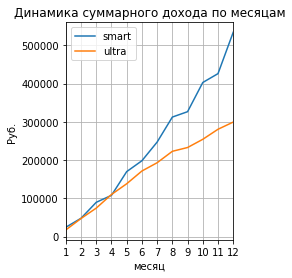

In [249]:
sum_revenue['smart'].plot(style='-', y= 'smart', grid=True, figsize=(3, 4), label= 'smart', legend=True)
sum_revenue['ultra'].plot(style='-', y='ultra', grid=True, figsize=(3, 4), label='ultra', legend=True)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.title("Динамика суммарного дохода по месяцам")
plt.xlabel("месяц")
plt.ylabel("Руб.")
plt.show()

Если в начале года тарифы приносили примено одинаковый доход, то к концу года тариф smartнабирает обороты, а ultra теряет скорость роста.

Сравним выручку тарифных планов Smart и Ulrta за весь год.

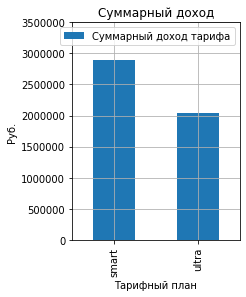

In [257]:
# Выручка от тарифного плана
(tariff_stat
     .pivot_table(index='tariff', values='total_income', aggfunc='sum')
     .plot(kind='bar', y='total_income', grid=True, figsize=(3, 4), label='Суммарный доход тарифа', ylim= [0,3500000])
)
plt.title("Суммарный доход")
plt.xlabel("Тарифный план")
plt.ylabel("Руб.")
plt.show()

Пользователи тарифа Smart приносят больше денег. Но это зависит и от количества пользователей.

Посмотрим сколько в среднем приносит пользователь того или иного тарифа.

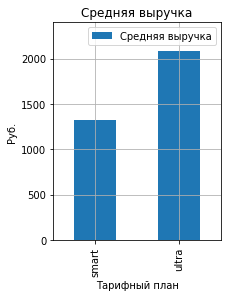

In [260]:
# Средняя выручка от тарифного плана
(tariff_stat
     .pivot_table(index='tariff', values='mean_income', aggfunc='mean')
     .plot(kind='bar', y='mean_income', grid=True, figsize=(3, 4), label='Средняя выручка', ylim= [0, 2400])
)
plt.title("Средняя выручка")
plt.xlabel("Тарифный план")
plt.ylabel("Руб.")
plt.show()

Больший средний доход приносит тарифный план "Ultra'. Но суммарный доход от тарифного плана Smart существенно выше, что говорит о том, что доля клиентов с тарифом Ultra значительно меньше.

Средний доход от клиента выше абонентской платы. Это значит, что на доход влияет не только абонентская плата но и перерасход стандартного пакета.

Чтобы посмотреть как влияет выбранный тарифный план на потребление услуг, посмотрим средние и стандартное отклоенение.

Посчитаем среднее и дисперсию, стандартное отклонение минут разговора по тарифам.

In [261]:
call_stat = months_stat.groupby('tariff')['duration'] \
            .agg({'mean','var'}) \
            .rename(columns={'mean':'mean', 'var':'dispersion'}) \
            .reset_index()
call_stat['std'] = np.sqrt(call_stat['dispersion'])
call_stat

,tariff,mean,dispersion,std
0,smart,419.062978,35844.189551,189.325618
1,ultra,545.451104,94203.418396,306.925754


В тарифнм плане Smart включено 500 минут. А среднее - 419 минут. Это говорит о том, что не все пользователи укладываются в пакет минут.

В тарифном плане Ultra включено 3000 минут. А среднее - 545 минут. Это говорит о том, что пакета минут хватает с избытком.

Посчитаем среднее и дисперсию, стандартное отклонение сообщений по тарифам.

In [262]:
messages_stat = months_stat.groupby('tariff')['messages'] \
            .agg({'mean','var'}) \
            .rename(columns={'mean':'mean', 'var':'dispersion'}) \
            .reset_index()
messages_stat['std'] = np.sqrt(messages_stat['dispersion'])
messages_stat

,tariff,mean,dispersion,std
0,smart,38.716441,717.594201,26.787949
1,ultra,61.161006,2109.659183,45.931026


Посчитаем среднее и дисперсию, стандартное отклонение траффика интернета по тарифам.

In [263]:
internet_stat = months_stat.groupby('tariff')['mb_used'] \
            .agg({'mean','var'}) \
            .rename(columns={'mean':'mean', 'var':'dispersion'}) \
            .reset_index()
internet_stat['std'] = np.sqrt(internet_stat['dispersion'])
internet_stat

,tariff,mean,dispersion,std
0,smart,16236.472621,3.444310e+07,5868.824472
1,ultra,19686.767179,9.904344e+07,9952.057054


Среднее


Превышения тарифов у нас сохранились в months_stat, поэтому можем посмотреть превышения графически.

**Тариф SMART**

Минуты разговора - превышение тарифа

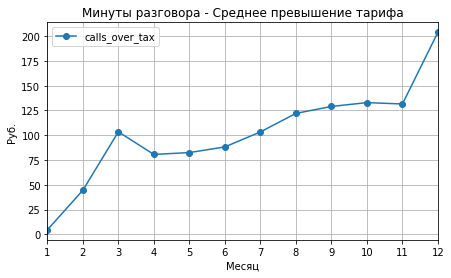

In [265]:
months_stat.query('tariff == "smart"') \
        .pivot_table(index='month', values= 'calls_over_tax', aggfunc='mean') \
        .plot(style='o-', legend=True, grid=True, figsize=(7, 4), label='Среднее превышение')
plt.title("Минуты разговора - Среднее превышение тарифа")
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.xlabel("Месяц")
plt.ylabel("Руб.")
plt.show()

Сообщения - превышение тарифа

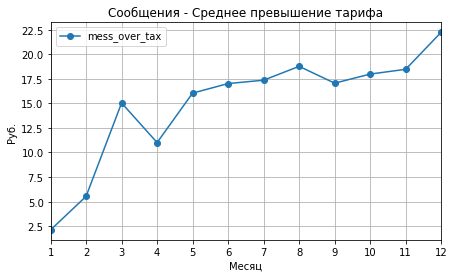

In [266]:
months_stat.query('tariff == "smart"') \
        .pivot_table(index='month', values= 'mess_over_tax', aggfunc='mean') \
        .plot(style='o-', legend=True, grid=True, figsize=(7, 4), label='Среднее превышение')
plt.title("Сообщения - Среднее превышение тарифа")
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.xlabel("Месяц")
plt.ylabel("Руб.")
plt.show()

Кол-во сообщений по месяцам

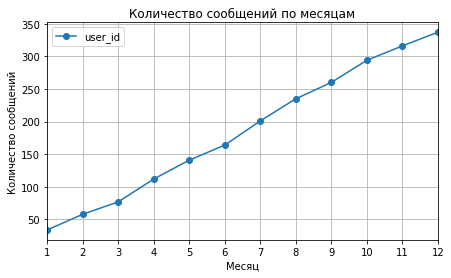

In [269]:
months_stat.query('tariff == "smart"') \
        .pivot_table(index='month', values= 'user_id', aggfunc='count') \
        .plot(style='o-', legend=True, grid=True, figsize=(7, 4), label='Количество сообщений')
plt.title("Количество сообщений по месяцам")
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.xlabel("Месяц")
plt.ylabel("Количество сообщений")
plt.show()

Интернет  - превышение тарифа

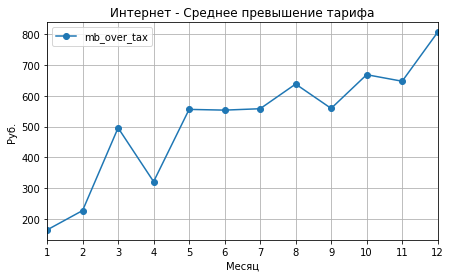

In [270]:
months_stat.query('tariff == "smart"') \
        .pivot_table(index='month', values= 'mb_over_tax', aggfunc='mean') \
        .plot(style='o-', legend=True, grid=True, figsize=(7, 4), label='Среднее превышение')
plt.title("Интернет - Среднее превышение тарифа")
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.xlabel("Месяц")
plt.ylabel("Руб.")
plt.show()

Пользователи тарифа smart приносят доход сверх абонентской платы за счет превышения минут, количества сообщений и трафика интернета. Причем, количество услуг сверх тарифа увеличивается, но не такими темпами, как прирост клиентов.

Это может указывать на то, что потребности пользователей выше тарифа. В условиях конкуренции пользователи могут уходить на более соответствующие их потребностям тарифы.

**Тариф ULTRA**

Минуты разговора  - превышение тарифа

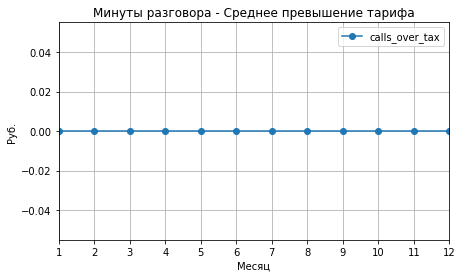

In [271]:
months_stat.query('tariff == "ultra"') \
        .pivot_table(index='month', values= 'calls_over_tax', aggfunc='mean') \
        .plot(style='o-', legend=True, grid=True, figsize=(7, 4), label='Среднее превышение')
plt.title("Минуты разговора - Среднее превышение тарифа")
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.xlabel("Месяц")
plt.ylabel("Руб.")
plt.show()

Сообщения  - превышение тарифа

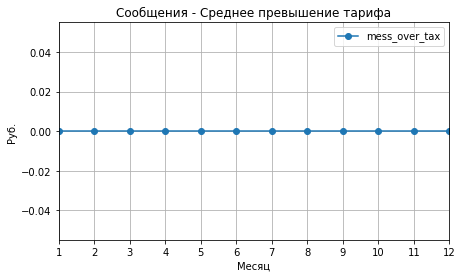

In [272]:
months_stat.query('tariff == "ultra"') \
        .pivot_table(index='month', values= 'mess_over_tax', aggfunc='mean') \
        .plot(style='o-', legend=True, grid=True, figsize=(7, 4), label='Среднее превышение')
plt.title("Сообщения - Среднее превышение тарифа")
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.xlabel("Месяц")
plt.ylabel("Руб.")
plt.show()

Интернет  - превышение тарифа

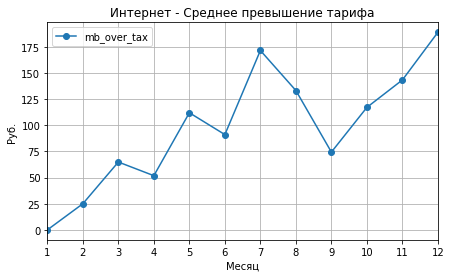

In [273]:
months_stat.query('tariff == "ultra"') \
        .pivot_table(index='month', values= 'mb_over_tax', aggfunc='mean') \
        .plot(style='o-', legend=True, grid=True, figsize=(7, 4), label='Среднее превышение')
plt.title("Интернет - Среднее превышение тарифа")
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.xlabel("Месяц")
plt.ylabel("Руб.")
plt.show()

Пользователи тарифа utra явно не используют весь пакет минут разговора и сообщений, но вынуждены доплачивать за интернет-трафик.

**Возрастные группы** в тарифе **smart**

Количество пользователей от возраста

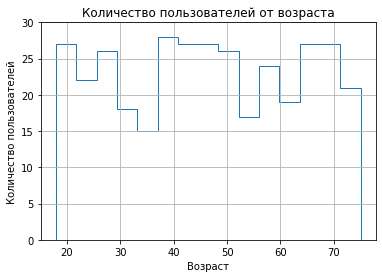

In [282]:
tariff_stat.query('tariff == "smart"') \
    .plot(kind='hist', y='age', histtype='step',
    bins=15, label='Кол-во пользователей', grid=True, legend=False, ylim= [0,30])
plt.title("Количество пользователей от возраста")
plt.xlabel("Возраст")
plt.ylabel("Количество пользователей")
plt.show()

Возрастные гуппы в тарифе ultra

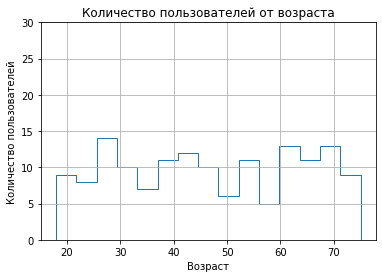

In [283]:
tariff_stat.query('tariff == "ultra"').plot(kind='hist', y='age', histtype='step',
          bins=15, label='Число пользователей', grid=True, legend=False, ylim= [0,30])
plt.title("Количество пользователей от возраста")
plt.xlabel("Возраст")
plt.ylabel("Количество пользователей")
plt.show()

Доход по возрастной группе

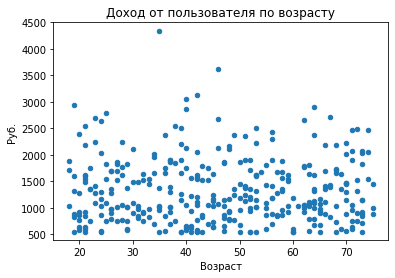

In [287]:
tariff_stat.query('tariff == "smart"').plot(x='age', y='mean_income', kind='scatter', ylim= [400,4500])
plt.title("Доход от пользователя по возрасту")
plt.xlabel("Возраст")
plt.ylabel("Руб.")
plt.show()

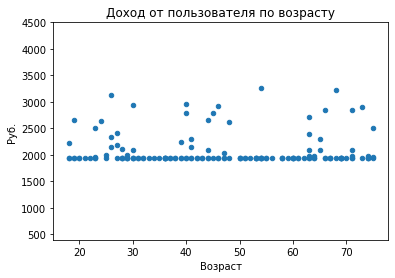

In [288]:
tariff_stat.query('tariff == "ultra"').plot(x='age', y='mean_income', kind='scatter', ylim= [400,4500])
plt.title("Доход от пользователя по возрасту")
plt.xlabel("Возраст")
plt.ylabel("Руб.")
plt.show()

По возрастным группам не выделяется каких-то существенно отличающихся групп.

Распределение дохода от пользователя в тарифе ultra показывает графически, что пользователи в основном, приносят доход в рамках тарифного плана.

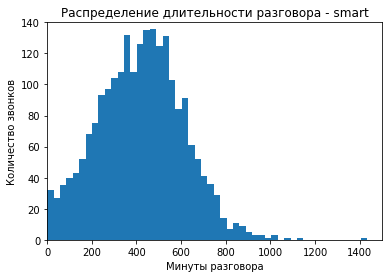

In [316]:
months_stat.query('tariff == "smart"') \
    .plot(kind= 'hist', y= 'duration', bins= 50, legend= False, ylim= [0,140], xlim= [0,1500])
plt.title("Распределение длительности разговора - smart")
plt.xlabel("Минуты разговора")
plt.ylabel("Количество звонков")
plt.show()

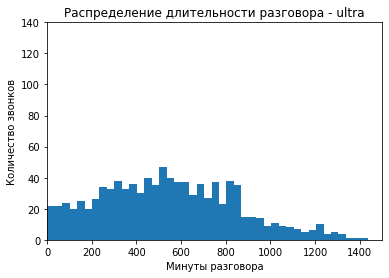

In [317]:
months_stat.query('tariff == "ultra"') \
    .plot(kind= 'hist', y= 'duration', bins= 50, legend= False, ylim= [0,140], xlim= [0,1500])
plt.title("Распределение длительности разговора - ultra")
plt.xlabel("Минуты разговора")
plt.ylabel("Количество звонков")
plt.show()

In [297]:
call_stat

,tariff,mean,dispersion,std
0,smart,419.062978,35844.189551,189.325618
1,ultra,545.451104,94203.418396,306.925754


<font style="color:purple">
В обоих случаях вид распределения Пуассоновский (стремящийся к нормальному).

Тариф Smart - характерен меньший разброс. Пользователи выбрали путь экономии. Но стандартного пакета им не хватает, т.к. среднее больше пакета.
    
Выбор тарифа Ultra позволяет пользователям не заботится о длительности звонка, поэтому разброс больше. Заметна существенная разница в количестве клиентов разговаривающих более 1000 минут в месяц.
    
2. Распределение количества сообщений.
</font>    

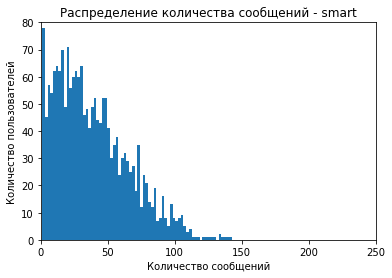

In [318]:
months_stat.query('tariff == "smart"') \
    .plot(kind= 'hist', y= 'messages', bins= 70, legend= False, ylim= [0,80], xlim= [0,250])
plt.title("Распределение количества сообщений - smart")
plt.xlabel("Количество сообщений")
plt.ylabel("Количество пользователей")
plt.show()

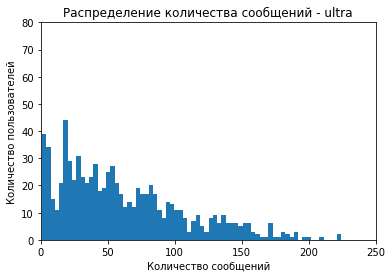

In [319]:
months_stat.query('tariff == "ultra"') \
    .plot(kind= 'hist', y= 'messages', bins= 70, legend= False, ylim= [0,80], xlim= [0,250])
plt.title("Распределение количества сообщений - ultra")
plt.xlabel("Количество сообщений")
plt.ylabel("Количество пользователей")
plt.show()

In [311]:
messages_stat

,tariff,mean,dispersion,std
0,smart,38.716441,717.594201,26.787949
1,ultra,61.161006,2109.659183,45.931026


<font style="color:purple">
В обоих случаях вид распределения можно назвать Пуассоновским (с длинным хвостом).
    
Здесь также заметно, что в тарифном плане ultra пользователи отправляют больше число собщений,но до пакетных 1000 очень далеко.

    
3. Распределение траффика интернет.
</font>    

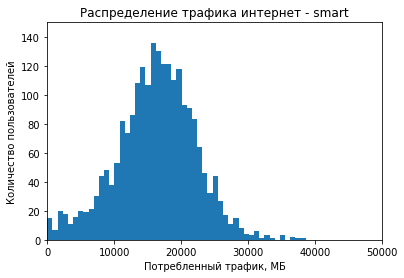

In [323]:
months_stat.query('tariff == "smart"') \
    .plot(kind= 'hist', y= 'mb_used', bins= 50, legend= False, ylim= [0,150], xlim= [0,50000])
plt.title("Распределение трафика интернет - smart")
plt.xlabel("Потребленный трафик, МБ")
plt.ylabel("Количество пользователей")
plt.show()

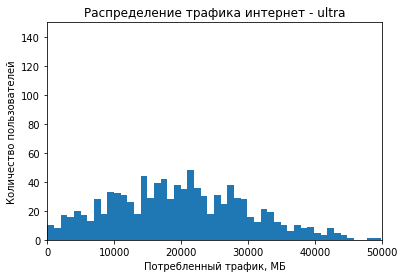

In [322]:
months_stat.query('tariff == "ultra"') \
    .plot(kind= 'hist', y= 'mb_used', bins= 50, legend= False, ylim= [0,150], xlim= [0,50000])
plt.title("Распределение трафика интернет - ultra")
plt.xlabel("Потребленный трафик, МБ")
plt.ylabel("Количество пользователей")
plt.show()

In [324]:
internet_stat

,tariff,mean,dispersion,std
0,smart,16236.472621,3.444310e+07,5868.824472
1,ultra,19686.767179,9.904344e+07,9952.057054


<font style="color:purple">
В обоих случаях вид распределения Пуассоновский (стремящийся к нормальному).

Тариф Smart - характерен меньший разброс. Среднее потебление трафика выше стандартного пакета. Вид распределения немного даже скошен влево, как бы намекая, что пользователи вынуждены себя ограничивать.
    
Существенная часть пользователей тарифа Ultra также превышает включенный пакет траффика.    
</font>    

### Вывод

В предсталенной выборке идет увеличение (линейное) кол-ва пользователей с каждым месяцем.

Ежемесячный доход от обоих тарифов был почти одинаковым в начале года, но к концу smart ускоряет рост, а ultra отстал и замедляет рост.

На конец года количество пользователей тарифа smart существенно больше и эта группа приносит основной доход.

Средняя выручка от пользователя ultra существенно выше.

Пользователи smart часто не укладываются в пакеты тарифного плана по всем видам услуг (звоки, сообщения, интерент), что создет доход сверх пакета.

Пользователи ultra недовыбирают услуги по минутам разговора и сообщениям, но перебирают услуги интернета.

In [ ]:
display(call_stat)
display(messages_stat)
display(internet_stat)

<a id="investigate"></a>
### Шаг 4. Проверка гипотез
<a id="hyp_01"></a>
#### Шаг 4.1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Сформулируем гипотезы.

*Нулевая гипотеза (равенство):*   Средняя выручка пользователей smart и ultra одинакова.

*Альтернативная гипотеза (неравенство):*   Средние выручки smart и ultra различаются

In [342]:
# Проверка гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам

# Сатистический уровень значимости
alpha = 0.05

# В функцию нужно передать выборки доходов от пользоватлей обоих тарифов
# Среднемесячная выручка по каждому пользователю у нас посчитана в tariff_stat['mean_income']
# Остается только разделить на пользователей разных тарифов
smart_revenue = tariff_stat.query('tariff == "smart"')['mean_income']
ultra_revenue = tariff_stat.query('tariff == "ultra"')['mean_income']

# Проверка гипотезы
results = st.ttest_ind(smart_revenue, ultra_revenue, equal_var = False)
# equal_var - считать ли равными дисперсии выборок, по умолчанию имеет значение True

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 


p-значение:  5.26252224448908e-59
Отвергаем нулевую гипотезу


<font style="color:purple">
Мы проверяем гипотезу о равенстве средних двух генеральных совокупностей.
equal_var = True при условиий, что обе совокупности имеют примерно равную дисперсию (совокупности схожи по параметрам).

    Если дисперсии выборок отличаются, параметр equal_var = False. При этом при оценке дисперсия каждой выборки будет осуществляться раздельно, а не по дисперсии обобщенной выборки.
  
Посчитаем дисперсии выборок. При расчете оценк выборки нас будет интересовать несмещенная оценка, поэтому параметр ddof=1.
</font>    

In [341]:
# дисперсия считается функцией var
smart_revenue_variance = np.var(smart_revenue, ddof=1)
ultra_revenue_variance = np.var(ultra_revenue, ddof=1)
print(smart_revenue_variance)
print(ultra_revenue_variance)

368949.21045947366
90024.3759870695


<font style="color:purple">
Убедились, что дисперсии выборок отличаются. Праметр equal_var = False выбран верно.
</font>    

<font style="color:purple">
Критерий Бартлетта проверяет равенство дисперсий выборок (0-я гипотеза). Критерий Бартлетта снован на дополнительном предположении о нормальности выборок данных и очень чувствителен к нарушению данного предположения.
    
Критерий Левена является альтернативой критерия Бартлетта в случае существенного отклонения от нормальности.
    
Попробуем.
</font>    

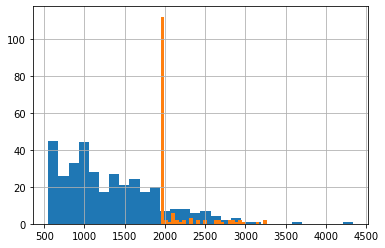

In [340]:
smart_revenue.hist(bins=30)
ultra_revenue.hist(bins=30)

In [337]:
from scipy.stats import levene

stat, p = levene(smart_revenue, ultra_revenue)
print(p)

from scipy.stats import bartlett
stat, p = bartlett(smart_revenue, ultra_revenue)
print(p)

1.174839894968326e-18
1.4822012091517145e-19


<font style="color:purple">
Выборки отклоняются от нормальног распределения. Верим критерию Бартлетта. Значение стремится к нулю. Выборки различаются.
</font>    

### Вывод

Нельзя подтвердить гипотезу, что средняя выручка пользователей smart и ultra одинакова.
Следовательно, подтверждаем, что средняя выручка от пользователей тарифов различается.

<a id="hyp_02"></a>
#### Шаг 4.2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Сформулируем гипотезы.

*Нулевая гипотеза (равенство):*  Средняя выручка пользователей из Москвы равна средней выручке от пользователей из других регионов.

*Альтернативная гипотеза (неравенство):*  Средняя выручка пользователей из Москвы и пользователей из других регионов не равны.

In [343]:
# В функцию нужно передать выборки доходов от пользоватлей обоих тарифов
# Среднемесячная выручка по каждому пользователю у нас посчитана в tariff_stat['mean_income']
# Остается только разделить на пользователей разных тарифов
moscow_revenue = tariff_stat.query('city == "Москва"')['mean_income']
not_moscow_revenue = tariff_stat.query('city != "Москва"')['mean_income']

<font style="color:purple">
Проверим характер распределений и равенство дисперсий.
</font>    

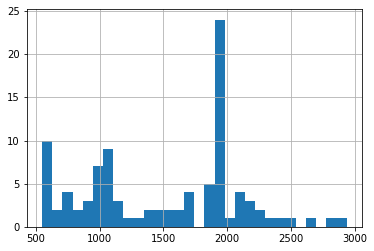

In [347]:
moscow_revenue.hist(bins=30)

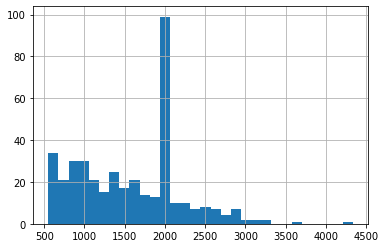

In [346]:
not_moscow_revenue.hist(bins=30)

In [349]:
# дисперсия считается функцией var
moscow_revenue_variance = np.var(moscow_revenue, ddof=1)
not_moscow_revenue_variance = np.var(not_moscow_revenue, ddof=1)
print(moscow_revenue_variance)
print(not_moscow_revenue_variance)

364839.96968346805
416629.0435412805


In [348]:
stat, p = bartlett(moscow_revenue, not_moscow_revenue)
print(p)

0.41217787165844977


<font style="color:purple">
Дисперсии довольно близки. При проверке гипотезы можно использовать параметр равенства дисперсий equal_var= True
</font>    

In [350]:
# Проверка гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам

# Сатистический уровень значимости
alpha = 0.05

# Проверка гипотезы
results = st.ttest_ind(moscow_revenue, not_moscow_revenue, equal_var = True)
# equal_var - считать ли равными дисперсии выборок, по умолчанию имеет значение True

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 


p-значение:  0.38656613797487016
Не получилось отвергнуть нулевую гипотезу


### Вывод
Нулевая гипотеза подтверждается: Средняя выручка пользоватлей из Москвы равна средней выручке пользователей из других регионов.

<a id="final"></a>
### Шаг 3. Общий вывод

Выводы написаны на каждом шагу.

Обобщая их можно сделать следующие выводы:

- Тарифный план smart на конец 2018 года приносит больший суммарный доход, т.к. идет более интенсивный рост количества пользователей и сумарного дохода. Доход от пользователей ultra растет, но динамика замедляется.

- Пользователи тарифного плана smart приносят дополнительный доход за счет пользования услугами свыше пакета услуг по всем видам услуг.

- Пользователи тарифного плана ultra не пользуются включенными пакетами минут разговора и сообщений в полном объеме, но допускают превышение трафика интернет.Соответственно, доход от клиента формируется в основном размером абонентской платы. Возможно, несоответствие пакета услуг потребностям снижает привлекательность тарифа.

- Средний доход от пользователя тарифа smart и ultra различаются. Средний доход от ultra выше.

- Средний доход от пользователя из Москвы не отличается от пользователей из других регионов.
